In [184]:
import json
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]
import numpy as np
np.set_printoptions(precision=3, linewidth=150)
import numbers
from pprint import pprint
from copy import copy
from itertools import combinations, chain, product

import networkx as nx

import sys
sys.path.insert(0, '/Users/nicibe/PythonFunctions')
from prinfo import prinfo

# Create Classes

In [185]:
class Road(object):
    def __init__(self, feature_dict):
        self.coordinates = np.array(feature_dict['geometry']['coordinates'])
        self.original_coordinates = np.array(feature_dict['geometry']['coordinates'])

        self.properties = feature_dict['properties']
        self.num_vertices = feature_dict['properties']['num_vertices']

        self.exagg_value = {0: 0, 1: 0}
    
    def __repr__(self):
        return f"Road with {self.properties['num_vertices']} vertices"

    def exaggerate_axis(self, axis, factor):
        if self.exagg_value[axis] != factor:
            self.coordinates = self.original_coordinates * 1
            self.coordinates[:, axis] *= factor
            self.exagg_value[axis] = factor

class Vertex(object):
    def __init__(self, index, road_index, coords, translation_vector, properties: list, connections):
        self.index = index
        self.road_index = road_index
        self.translation_vector = translation_vector

        for i in properties:
            assert isinstance(i, numbers.Number)


        self.coords = copy(coords)
        self.properties = np.array(self.coords + properties + translation_vector)

        self.connections = connections

    def __str__(self):

        lines = []

        lines.append(f"Vertex {self.index}")
        lines.append(f"Coordinates: {[np.round(coord, 2) for coord in self.coords]}")
        lines.append(f"Connections: {self.connections}")

        lines.append(f"Attributes: {self.properties}")
        # lines.append("\n")

        return "\n".join(lines)
    
    def __repr__(self):
        return f"Vertex {self.index}"

class Graph(object):
    def __init__(self, nodes):
        self.nodes = nodes

        self.adj_matrix = np.zeros((len(self.nodes), len(self.nodes)))
        
        for node in self.nodes:
            for connection in node.connections:
                self.adj_matrix[node.index, connection] = 1
        
        self.node_dict = {node.index: {
            "coords": node.coords,
            "transl": node.translation_vector,
            "props": node.properties} for node in self.nodes}

    def __repr__(self):
        return f"Graph: {len(self.nodes)} Nodes"


# Import original scale

In [186]:
with open("../data/geodata/small_subset/roads_zh_curvy_9features.geojson", "r") as roadjson:
    original_roads = json.load(roadjson)

original_road_list = [Road(road) for road in original_roads['features']]

for road in original_road_list:
    print(road)

Road with 2 vertices
Road with 12 vertices
Road with 258 vertices
Road with 10 vertices
Road with 8 vertices
Road with 127 vertices
Road with 14 vertices
Road with 145 vertices
Road with 7 vertices


# Import generalized scale

In [187]:
with open("../data/geodata/small_subset/roads_zh_curvy_smooth_9features.geojson", "r") as roadjson:
    smoothed_roads = json.load(roadjson)

smoothed_road_list = [Road(road) for road in smoothed_roads['features']]

for road in smoothed_road_list:
    print(road)

Road with 2 vertices
Road with 12 vertices
Road with 258 vertices
Road with 10 vertices
Road with 8 vertices
Road with 127 vertices
Road with 14 vertices
Road with 145 vertices
Road with 7 vertices


# Compute Translation Vectors and visualize

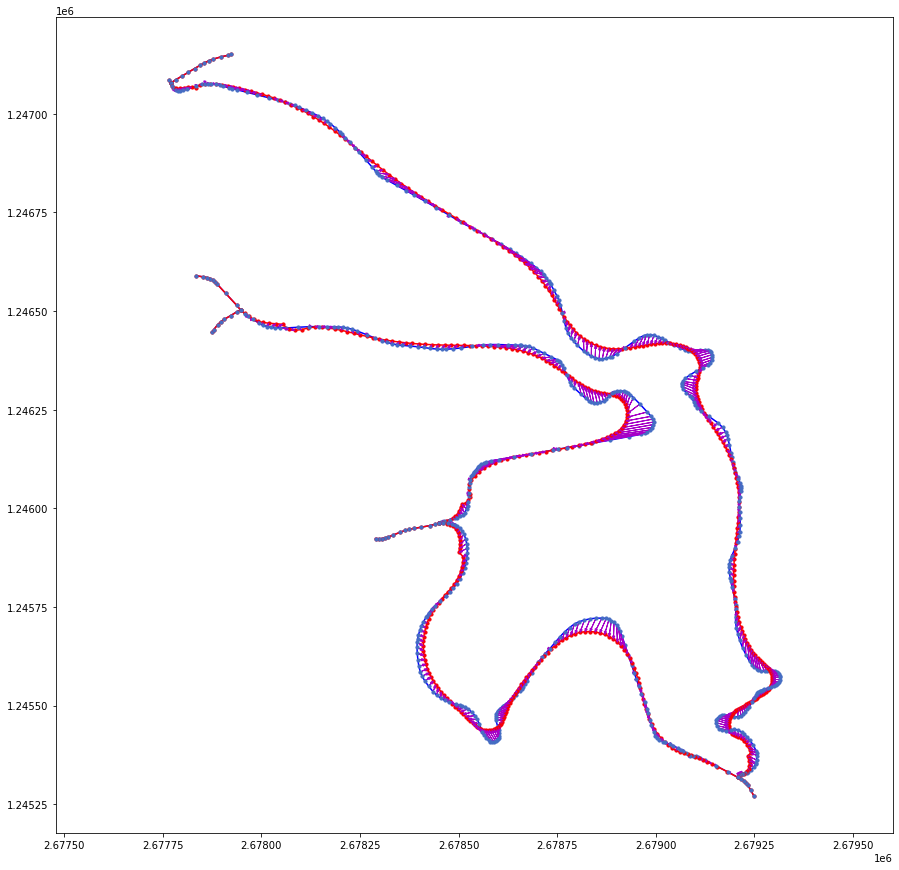

In [188]:
skip_vertices = 0
end = 1000000

exagg_x_axis = 1

plt.figure()
plt.axis('equal')

d = {}

# loop over roads indices
for i in range(len(original_road_list)):
    if i == i:
        d[i] = {
            'orig': {
                'properties': original_road_list[i].properties,
                'coordinates': []
            },
            'smooth': {
                'properties': smoothed_road_list[i].properties,
                'coordinates': []
            },
            'transl': {
                'coordinates': [],
                'vectors': []
            }}

        original_road_list[i].exaggerate_axis(0, exagg_x_axis)
        smoothed_road_list[i].exaggerate_axis(0, exagg_x_axis)

        plt.plot(
            original_road_list[i].coordinates[skip_vertices:end, 0],
            original_road_list[i].coordinates[skip_vertices:end, 1],
            color='blue',
            zorder=0)
        plt.plot(
            smoothed_road_list[i].coordinates[skip_vertices:end, 0],
            smoothed_road_list[i].coordinates[skip_vertices:end, 1],
            color='red',
            zorder=0)

        # loop over road vertices' indices
        for j in range(original_road_list[i].properties['num_vertices']):

            if not (end > j >= skip_vertices):
                continue

            orig_vertex = np.array(original_road_list[i].coordinates[j])
            smooth_vertex = np.array(smoothed_road_list[i].coordinates[j])
            translation_vector = smooth_vertex - orig_vertex 

            d[i]['orig']['coordinates'].append(list(orig_vertex))
            d[i]['smooth']['coordinates'].append(list(smooth_vertex))
            d[i]['transl']['coordinates'].append([list(orig_vertex), [orig_vertex[0] + translation_vector[0], orig_vertex[1] + translation_vector[1]]])
            d[i]['transl']['vectors'].append(list(translation_vector))

            
            if False:
                print(orig_vertex)
                print(smooth_vertex)
                print(translation_vector)
                print()


            plt.scatter(smooth_vertex[0], smooth_vertex[1], color=(248/256, 0, 5/256), s=10)
            plt.arrow(
                orig_vertex[0], orig_vertex[1],
                translation_vector[0], translation_vector[1],
                color=(168/256, 0, 200/256),
                head_width=6,
                head_length=8,
                length_includes_head=True)
            plt.scatter(orig_vertex[0], orig_vertex[1], color=(69/256, 109/256, 196/256), s=10)
            
            


plt.savefig('transl', dpi=600)                      


# Save to GEOJSON

In [189]:
transl_geojson_dict = {
"type": "FeatureCollection",
"name": "roads_zh_curvy_translation_vectors",
"crs": { "type": "name", "properties": { "name": "urn:ogc:def:crs:EPSG::2056" } },
"features": []
}

for i in range(len(d)):
    transl_geojson_dict['features'].append(
        { 
            "type": "Feature",
            "properties": {"id": i},
            "geometry": {
                "type": "MultiLineString",
                "coordinates": d[i]['transl']} }
    )


# with open("../data/geodata/small_subset/roads_zh_curvy_translation_vectors.geojson", "w") as transl_file:
#     json.dump(transl_geojson_dict, transl_file)

# Transform to graph

In [190]:
for i, el in enumerate(d):
    print("----------------------------------------")
    print(i)
    for j in d[i]:
        print("\t", j)
        for k in d[i][j]:
            print("\t\t", k)
    if i == 1:
        break

----------------------------------------
0
	 orig
		 properties
		 coordinates
	 smooth
		 properties
		 coordinates
	 transl
		 coordinates
		 vectors
----------------------------------------
1
	 orig
		 properties
		 coordinates
	 smooth
		 properties
		 coordinates
	 transl
		 coordinates
		 vectors


In [191]:
global_vertex_index = 0
orig_vertices = []

# iterate over roads
for i_road in range(len(d)):

    # create road-specific properties dictionary
    roadprops = d[i_road]['orig']['properties']
    props = [
        roadprops['BEFAHRBARK'],
        roadprops['BELAGSART'],
        roadprops['OBJEKTART'],
        roadprops['length'],
        roadprops['num_vertices']]

    # iterate over vertices
    for i_vertex in range(d[i_road]['orig']['properties']['num_vertices']):

        if i_vertex == 0:
            connections = [global_vertex_index + 1]
        elif i_vertex == d[i_road]['orig']['properties']['num_vertices'] - 1:
            connections = [global_vertex_index - 1]
        else:
            connections = [global_vertex_index - 1, global_vertex_index + 1]
        

        orig_vertices.append(
            Vertex(
                index=              global_vertex_index,
                road_index=         i_road,
                coords=             d[i_road]['orig']['coordinates'][i_vertex],
                translation_vector= d[i_road]['transl']['vectors'][i_vertex],
                properties=         props,
                connections=        connections
            )
        )
        
        global_vertex_index += 1


index_change_dict = {}
num_vertices = len(orig_vertices)




In [192]:
for i, j in combinations(iterable=range(num_vertices), r=2):
    if orig_vertices[i].coords == orig_vertices[j].coords:

        if orig_vertices[i].index == 271:
            print("-----------------------------------")
            print(orig_vertices[i])
            print(orig_vertices[j])

        # combine all connections
        new_connections = []
        for connection in orig_vertices[i].connections + orig_vertices[j].connections:
            if connection not in new_connections:
                new_connections.append(connection)

        # dictionary: old -> new
        index_change_dict[orig_vertices[j].index] = orig_vertices[i].index

        # update connections
        orig_vertices[i].connections = copy(new_connections)
        # overwrite second vertex
        orig_vertices[j] = orig_vertices[i]

prinfo(index_change_dict)

# create list with unique vertices
unique_vertices = list(dict.fromkeys(orig_vertices))
# for vertex in orig_vertices:
#     if vertex not in unique_vertices:
#         unique_vertices.append(vertex)




-----------------------------------
Vertex 271
Coordinates: [2679207.16, 1245318.27]
Connections: [270]
Attributes: [2.679e+06 1.245e+06 2.000e+00 2.000e+02 1.100e+01 3.122e+03 2.580e+02 0.000e+00 0.000e+00]
Vertex 431
Coordinates: [2679207.16, 1245318.27]
Connections: [432]
Attributes: [2.679e+06 1.245e+06 2.000e+00 2.000e+02 1.100e+01 1.769e+03 1.450e+02 0.000e+00 0.000e+00]
-----------------------------------
Vertex 271
Coordinates: [2679207.16, 1245318.27]
Connections: [270, 432]
Attributes: [2.679e+06 1.245e+06 2.000e+00 2.000e+02 1.100e+01 3.122e+03 2.580e+02 0.000e+00 0.000e+00]
Vertex 582
Coordinates: [2679207.16, 1245318.27]
Connections: [581]
Attributes: [2.679e+06 1.245e+06 2.000e+00 2.000e+02 1.100e+01 6.405e+01 7.000e+00 0.000e+00 0.000e+00]
-----------------------------------
Vertex 271
Coordinates: [2679207.16, 1245318.27]
Connections: [270, 432, 581]
Attributes: [2.679e+06 1.245e+06 2.000e+00 2.000e+02 1.100e+01 3.122e+03 2.580e+02 0.000e+00 0.000e+00]
Vertex 271
Coordi

#### Old way

In [193]:

# # vertices that are spatially the same should have the same id and connections
# for i in range(num_vertices):
#     for j in range(i+1, num_vertices):
#         if orig_vertices[i].coords == orig_vertices[j].coords:


#             if orig_vertices[i].index == 271:
#                 print("-----------------------------------")
#                 print(orig_vertices[i])
#                 print(orig_vertices[j])

#             # combine all connections
#             new_connections = []
#             for connection in orig_vertices[i].connections + orig_vertices[j].connections:
#                 if connection not in new_connections:
#                     new_connections.append(connection)

#             # dictionary: old -> new
#             index_change_dict[orig_vertices[j].index] = orig_vertices[i].index

#             # update connections
#             orig_vertices[i].connections = copy(new_connections)
#             # overwrite second vertex
#             orig_vertices[j] = orig_vertices[i]

# prinfo(index_change_dict)

# # create list with unique vertices
# unique_vertices = []
# for vertex in orig_vertices:
#     if vertex not in unique_vertices:
#         unique_vertices.append(vertex)



## Ensure continuous indices

In [194]:

# change connections according to change-dictionary
for vertex in unique_vertices:
    for i_connection, connection in enumerate(vertex.connections):
        if connection in index_change_dict:
            vertex.connections[i_connection] = index_change_dict[connection]

# ensure continuous indices
for i_vertex, vertex in enumerate(unique_vertices):
    if vertex.index != i_vertex:
        index_change_dict[vertex.index] = i_vertex
        vertex.index = i_vertex
    
    
# change connections according to change-dictionary
for vertex in unique_vertices:
    for i_connection, connection in enumerate(vertex.connections):
        if connection in index_change_dict:
            vertex.connections[i_connection] = index_change_dict[connection]
    

    
# index_change_dict


# Create Graph

In [195]:
g = Graph(unique_vertices)
G = nx.from_numpy_matrix(g.adj_matrix)
nx.set_node_attributes(G, g.node_dict)

# plt.imshow((g.adj_matrix))


In [196]:
print(g.nodes[286])

Vertex 286
Coordinates: [2677938.77, 1246498.8]
Connections: [285, 270]
Attributes: [2.678e+06 1.246e+06 2.000e+00 2.000e+02 1.100e+01 9.401e+01 8.000e+00 0.000e+00 0.000e+00]


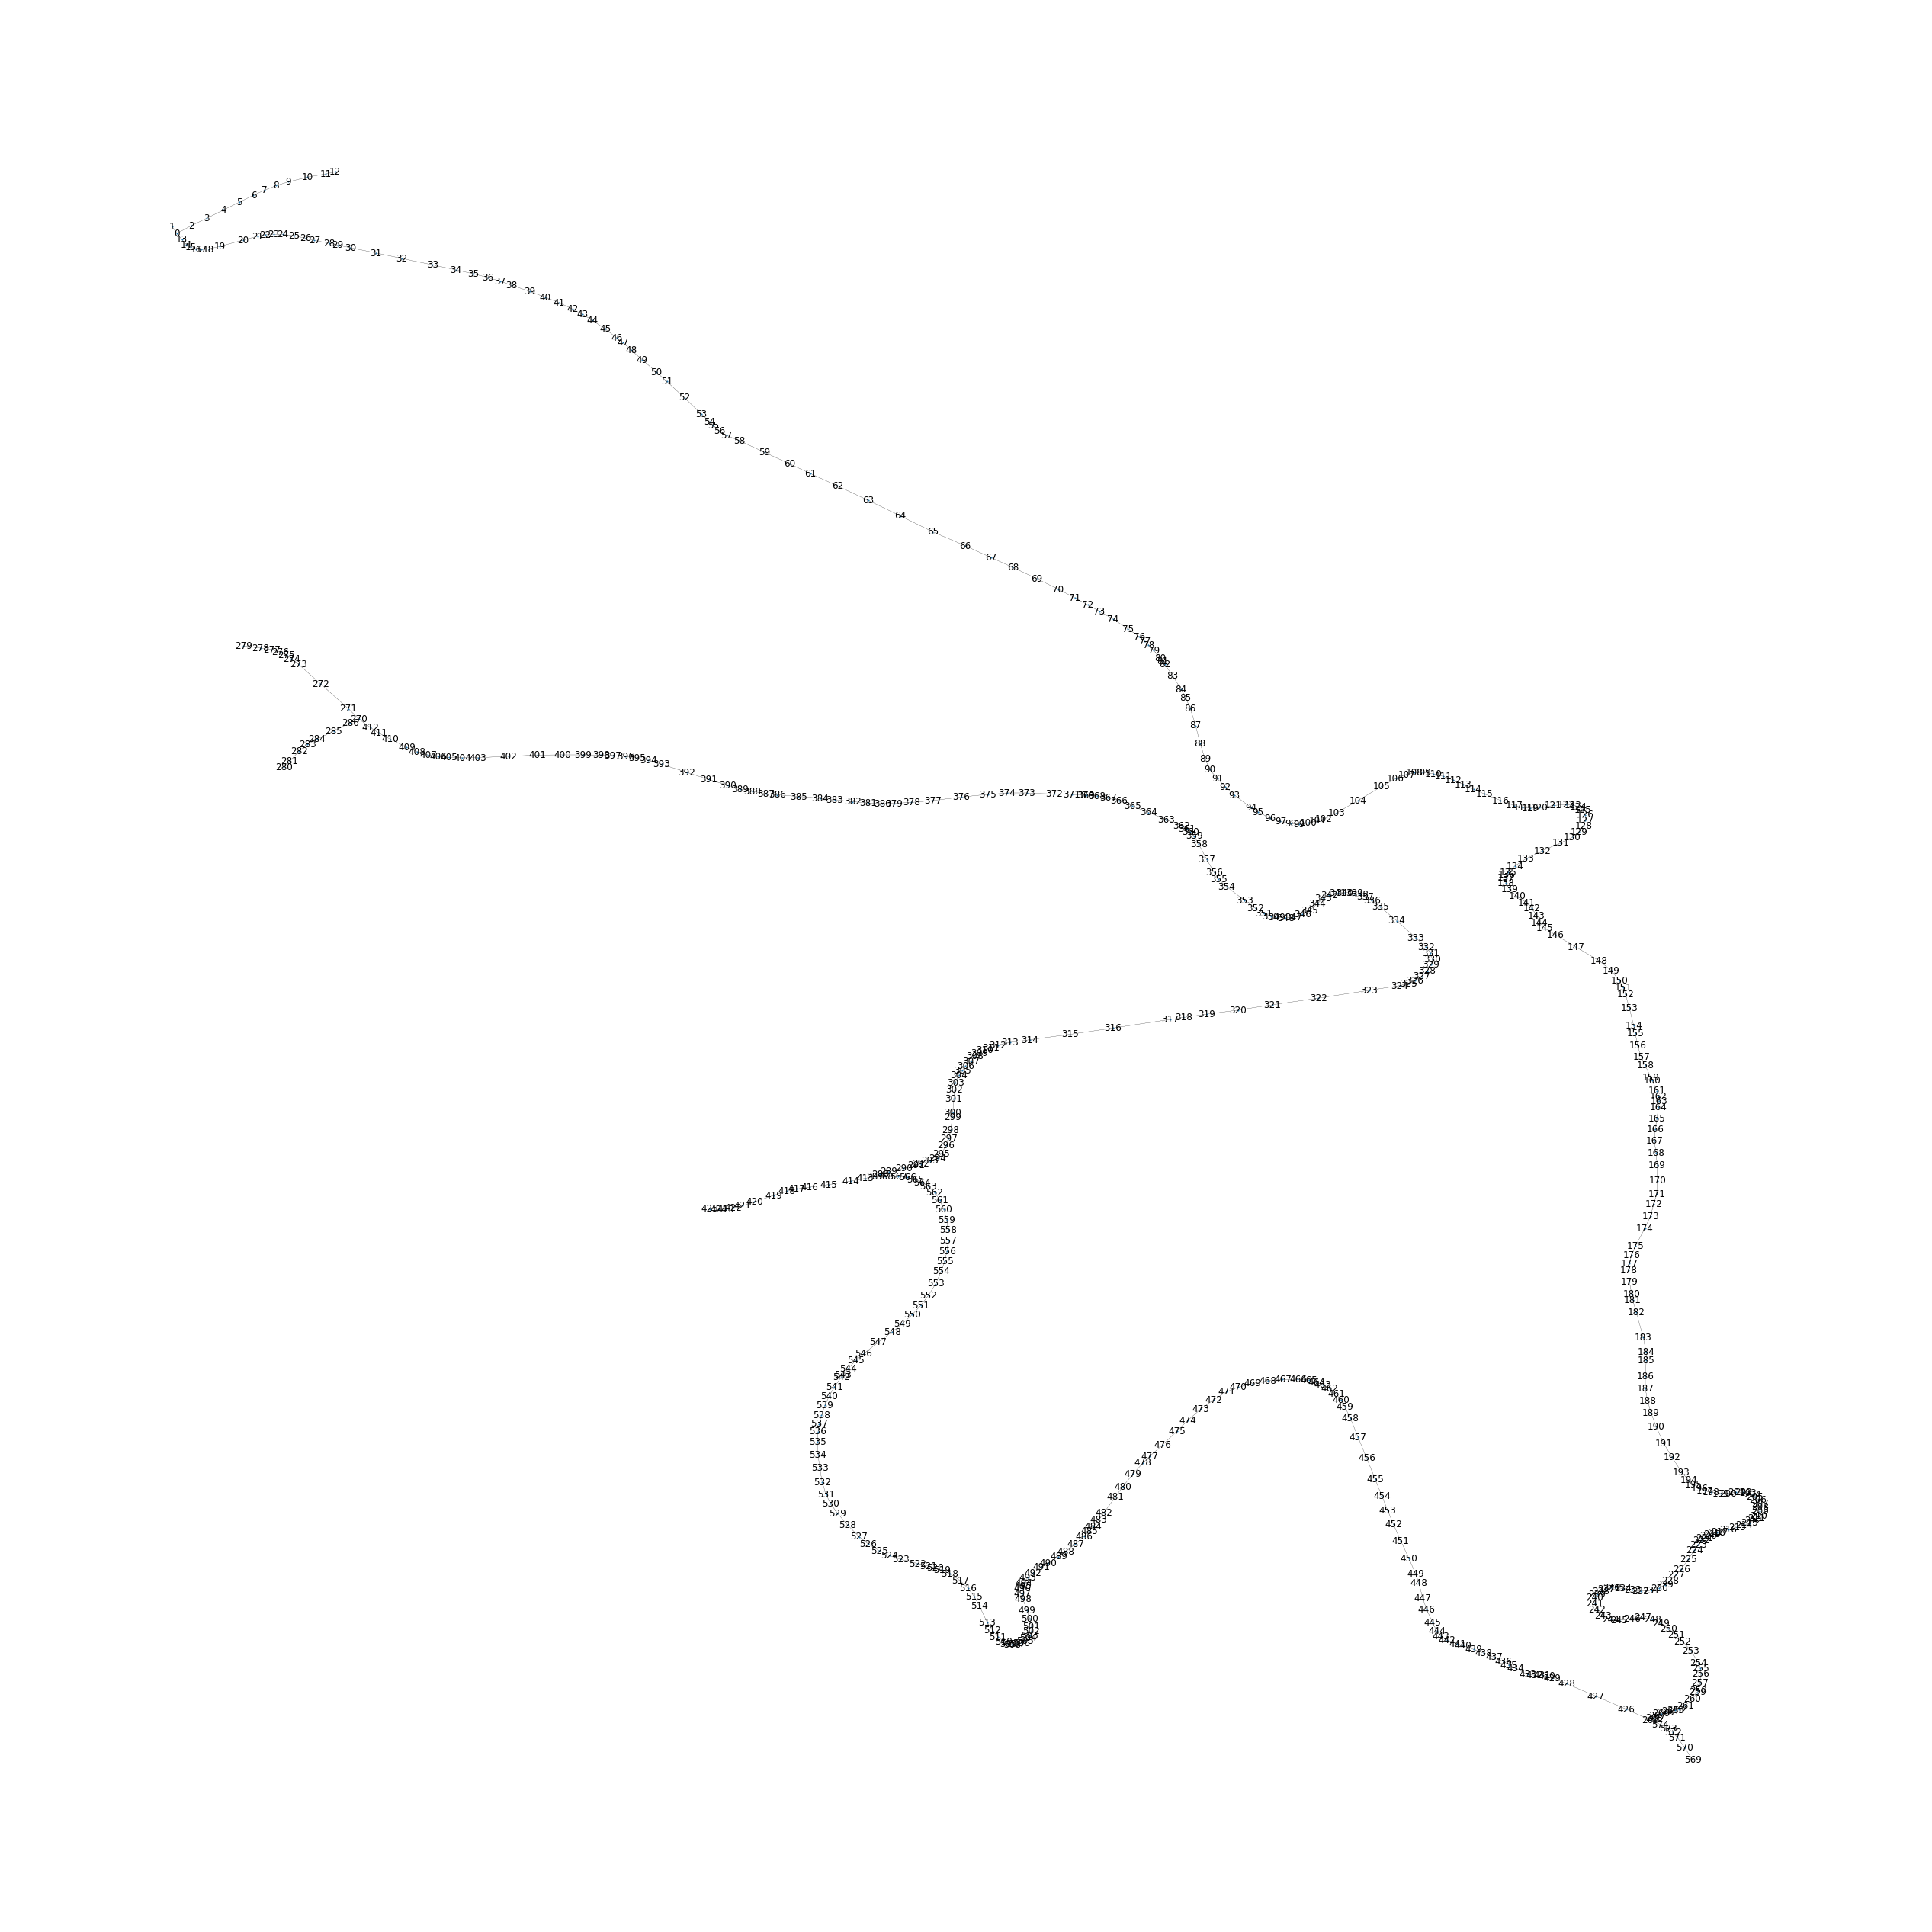

In [205]:

plt.figure(figsize=(35, 35))
nx.draw(G,  {n: G.nodes[n]['coords'] for n in list(G.nodes)}, width=0.25, node_size=1, with_labels=True)
# plt.savefig('roads_networkx', dpi=300)


In [199]:
G.nodes[200]

{'coords': [2679282.4219999984, 1245586.686999999],
 'transl': [-13.790774916298687, 23.21164604043588],
 'props': array([ 2.679e+06,  1.246e+06,  2.000e+00,  2.000e+02,  1.100e+01,  3.122e+03,  2.580e+02, -1.379e+01,  2.321e+01])}